In [253]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import plot_flow_on_sphere, plot_3d_points
from utils.manifold_utils import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import SoftDTW
import os
from tqdm import tqdm
from typing import Dict, Any

In [254]:
torch.manual_seed(3420934659826)

In [255]:
run_parameters =  yaml.safe_load(Path("./configs/exp_proj.yaml").read_text())
run_parameters

{'train': {'lr': 0.0002,
  'epochs': 25001,
  'batch_size': 100,
  'inf_every': 5000,
  'print_every': 5000,
  'device': 'cpu',
  'inf_runs_num': 3,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 3,
  'manifold_data': 'Sphere',
  'manifold_inference': 'None',
  'type_inference': 'None',
  'datasets': ['Sine'],
  'horizon_size': 8,
  'inference_horizon': 4,
  'scale_factor': 2.0,
  'downsample': 5,
  'sample_points': 200,
  'mean': 0.0,
  'std': 1.0},
 'ema': {'warmup': 1000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 5000, 'gamma': 0.5}}

In [256]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
train_sets= list(range(6)) # + list(range(7, 13)) # + list(range(14, 20)) + list(range(21, 27))
val_sets = [6] # 13, 20, 27]
print(train_sets, val_sets)

[0, 1, 2, 3, 4, 5] [6]


In [257]:
manifold_data = manifold_types[run_parameters['data']['manifold_data']]
manifold_inference = manifold_types[run_parameters['data']['manifold_inference']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold_data=manifold_data,
                               manifold_inference=manifold_inference,
                               type_inference=run_parameters['data']['type_inference'],
                               dim_to=run_parameters['data']['dim'])

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_horizon.shape)

7
1
6
torch.Size([1, 200, 8, 3])


In [258]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e

In [259]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(LASA_datasets)
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 77320


In [260]:
# run_name = "p_shape_sphere_3D"
# vf.load_state_dict(torch.load(os.path.join("./runs", run_name, "best_model.pth"), weights_only=True))
# ema_vf = ExponentialMovingAverage(
#     vf.parameters(),
#     decay = run_parameters['ema_decay'],
# )
# run_parameters['lr'] = 1e-5
# run_parameters['epochs'] = 30001

In [261]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=True)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            train_loss = step(vf=vf, 
                              batch=batch, 
                              run_parameters=run_parameters, 
                              manifold=manifold, 
                              path=path, 
                              device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step(vf=vf, 
                                    batch=val_batch, 
                                    run_parameters=run_parameters, 
                                    manifold=manifold, 
                                    path=path, 
                                    device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    best_val_loss = min(best_val_loss, loss_val.item())
                        
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=manifold,
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs)
                    
                    for label_name in infered.keys():
                        # infered[label_name]['results'] = dataset.return_data_from_inference_manifold(result_data=infered[label_name]['results'][0], start=dataset.start_points['Sine'])
                        # infered[label_name]['samples'] = dataset.return_data_from_inference_manifold(result_data=infered[label_name]['samples'][0], start=dataset.start_points['Sine'])
                        plot_flow_on_sphere(infered[label_name]['results'], 
                                            infered[label_name]['samples'], 
                                            gt_obs[dataset.get_label_maping()[label_name]],
                                            label=label_name,
                                            line_type='.--')
                    ema_vf.restore()
                start_time = time.time()
                plt.figure()
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(save_path,'loss_plot.png'))
                plt.close()

                plt.figure()
                plt.plot(lrs, label='Learning rate')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('lr')
                plt.legend()
                plt.savefig(os.path.join(save_path,'lr_plot.png'))
                plt.close()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        
        


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

| iter      0 |  0.02 sec | train loss    0.419 
| iter      0 | validation loss:    0.471 


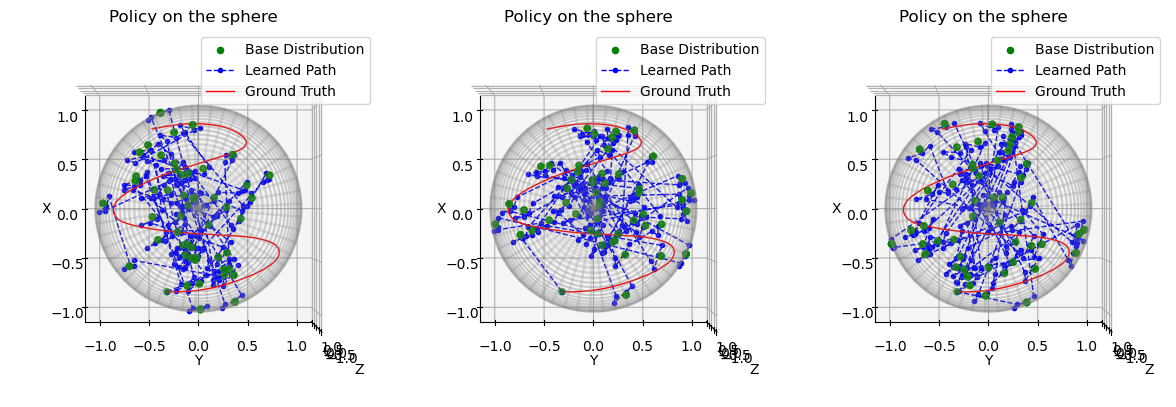

| iter   5000 | 54.92 sec | train loss    0.008 
| iter   5000 | validation loss:    0.011 


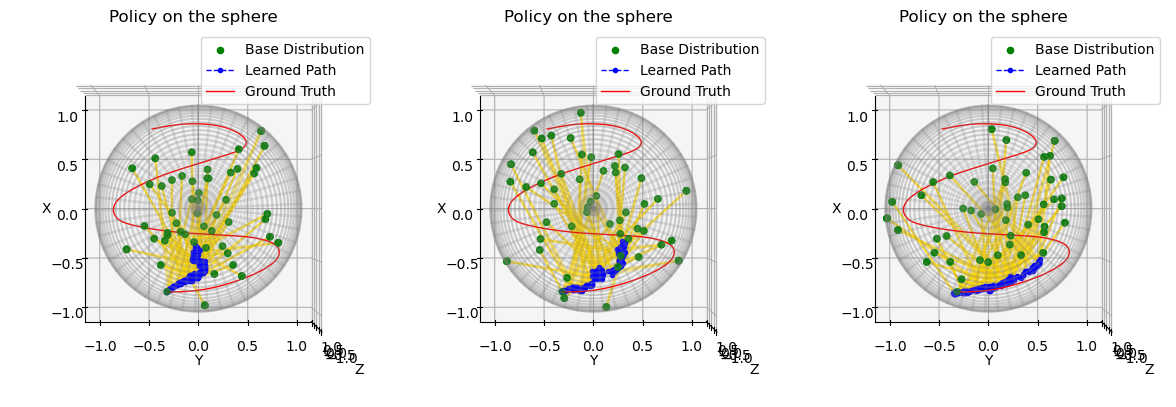

| iter  10000 | 54.02 sec | train loss    0.006 
| iter  10000 | validation loss:    0.006 


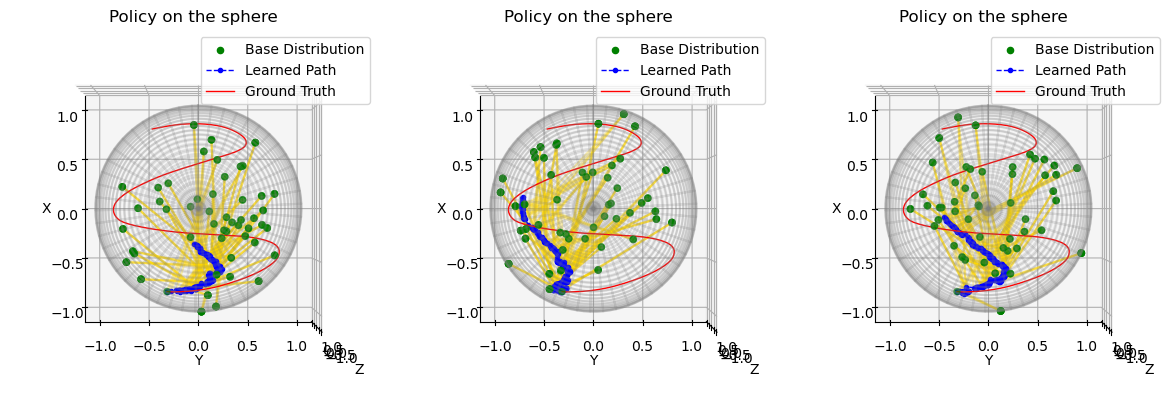

| iter  15000 | 54.15 sec | train loss    0.004 
| iter  15000 | validation loss:    0.004 


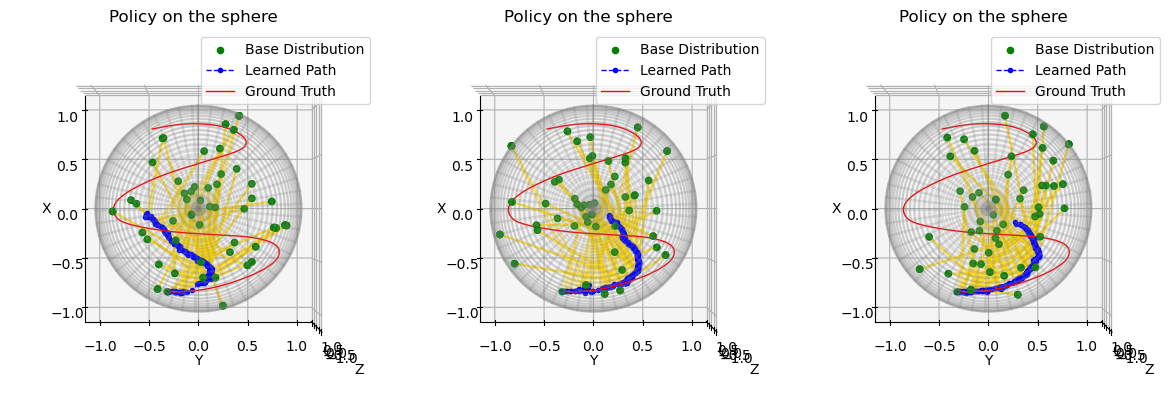

| iter  20000 | 55.33 sec | train loss    0.003 
| iter  20000 | validation loss:    0.006 


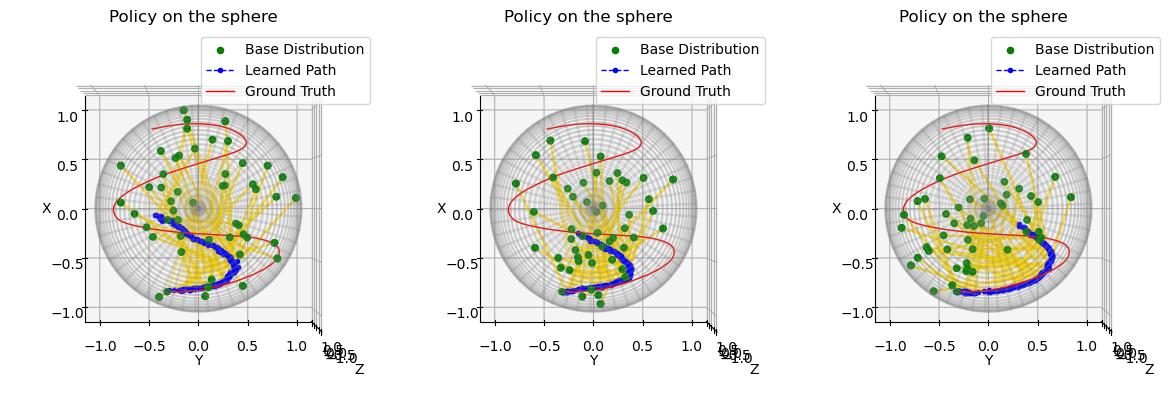

| iter  25000 | 53.93 sec | train loss    0.004 
| iter  25000 | validation loss:    0.003 


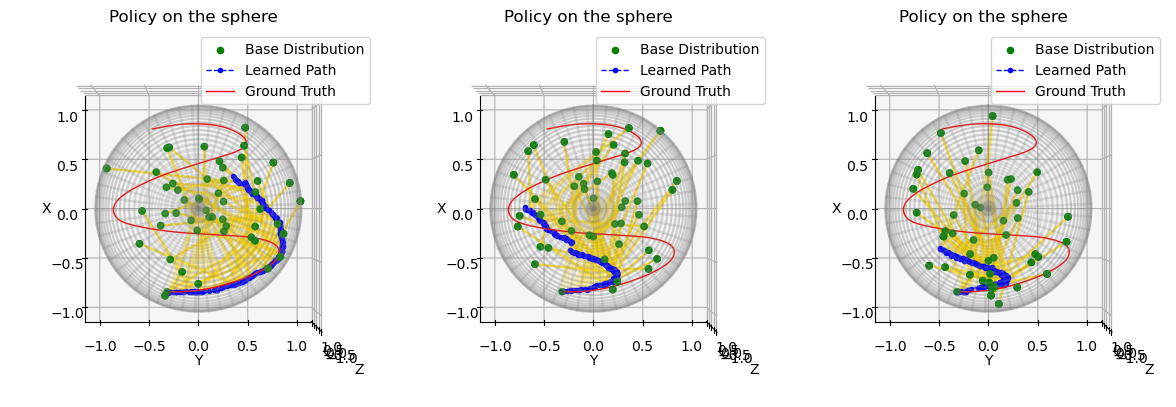

In [262]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold_data,
            ema_vf=ema_vf, 
            dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="sine_euclidean_3D")

In [263]:
ema_vf.store()
ema_vf.copy_to()

In [264]:
criterion =  SoftDTW(gamma=1.0, normalize=True)

In [265]:
class_labels = dataset.get_label_maping()
for label_name in list(class_labels.keys()):
    results = []
    samples = []
    errors = []
    for _ in range(10): #run_parameters['train']['inf_runs_num']):
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        res, samp, paths = infer_model(model=vf, 
                        start=gt_obs[class_labels[label_name],0,:run_parameters['data']['dim']], 
                        manifold=manifold_data,
                        label=label,
                        dim_manifold=run_parameters['data']['dim'],
                        model_horizon= run_parameters['data']['horizon_size'],
                        inference_horizon=run_parameters['data']['inference_horizon'],
                        sample_points=run_parameters['data']['sample_points'] + 20,
                        mean=run_parameters['data']['mean'],
                        std=run_parameters['data']['std'],
                        step_size=0.05,
                        return_intermediates=True)
        # res = dataset.return_data_from_inference_manifold(result_data=res, start=dataset.start_points['Sine'])
        # samp = dataset.return_data_from_inference_manifold(result_data=samp, start=dataset.start_points['Sine'])
        results.append(res)
        samples.append(samp)
        for sample in tqdm(range(len(paths)), desc="Path error", leave=False):
            path = paths[sample]
            for i in range(path.shape[2]):
                real_geodesic = sample_uniform_geodesic_path(manifold=manifold_data, 
                                                            start=path[0,0,i,:], #[1/step, b, horizon, dim]
                                                            finish=path[-1,0,i,:],
                                                            num_points=path.shape[0])
                errors.append(curve_geodesic_MSE(manifold=manifold_data, 
                                                x_curve=real_geodesic, 
                                                y_curve=path[:,0,i,:]))
        
    plot_flow_on_sphere(results, samples, gt_obs[class_labels[label_name]], label=label_name, dynamic=True, plot_samples=False, one_canvas=True, line_type='--')
    # print(np.array(errors).mean())

Output()

In [230]:
print(results[0][:200].shape)

torch.Size([200, 3])


In [231]:
print(gt_obs.shape)

torch.Size([1, 200, 7])


In [235]:
dtwd = []
for res in results:
    dtwd.append(criterion(gt_obs[0,:150, :3], res[:150]).item())
print(dtwd)

[23.136260986328125, 18.12005615234375, 27.81756591796875, 26.426773071289062, 17.370880126953125, 24.003494262695312, 17.623626708984375, 26.563552856445312, 36.62504577636719, 19.387924194335938]


In [266]:
def geodesic_distance(p, q):
    dot = torch.clamp(torch.sum(p * q, dim=-1), -1.0, 1.0)
    return torch.arccos(dot)

def evaluate_model_on_manifold(model,
                                dim_manifold,
                                label,
                                dataset,
                                method:str="midpoint",
                                manifold:Manifold=None,
                                step_size:float=0.01, 
                                sample_points:int=1000, 
                                inference_horizon:int=4,
                                model_horizon:int=8,
                                mean:float=0.0,
                                std:float=1.0,
                                verbose=False):
    
    T = torch.tensor([0.0,1.0])
    gt_obs = dataset.demos_gt[6] if len(dataset.demos_gt) != 0 else dataset.demos[6]
    errors = []
    for step_idx in tqdm(range(gt_obs.shape[0]), desc="Sampling trajectory", leave=False):
        c, tau_minus_c = sample_context(idx=step_idx, sample_points=sample_points)
        context = torch.cat([gt_obs[step_idx], gt_obs[c], tau_minus_c]).unsqueeze(0)

        wrapped_vf = WrappedVF(model=model,
                                obs=context,
                                label=label)
        wrapped_vf.eval()

        a0 = sample_normal_source(dim=2, 
                                    horizon=model_horizon, 
                                    manifold=manifold, 
                                    mean=mean,
                                    std=std,
                                    dim_to=dim_manifold)


        solver = RiemannianODESolver(velocity_model=wrapped_vf, 
                                        manifold=manifold)
        a_infer = solver.sample(                #[1, HOR, DIM]
                        x_init=a0,
                        step_size=step_size,
                        method=method,
                        verbose=verbose,
                        time_grid = T 
                    )
        a_infer=a_infer[0]
        errors.append(geodesic_distance(a_infer[:(gt_obs.shape[0] - step_idx)], gt_obs[step_idx : step_idx + a_infer.shape[0]]).mean())
        
    return errors

from mpl_toolkits.mplot3d import Axes3D

def plot_error_on_sphere(obs_coordinate, error):
    """
    Visualizes points on the sphere where each point is colored based on its error value.

    Args:
        obs_coordinate (torch.Tensor or np.ndarray): Array of shape (N, 3) containing (x, y, z) coordinates on the sphere.
        error (torch.Tensor or np.ndarray): Array of shape (N,) containing error values for each point.
    """

    obs_coordinate = obs_coordinate.cpu().numpy() if isinstance(obs_coordinate, torch.Tensor) else obs_coordinate
    error = error.cpu().numpy() if isinstance(error, torch.Tensor) else error

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    scatter = ax.scatter(obs_coordinate[:, 0], obs_coordinate[:, 1], obs_coordinate[:, 2],
                         c=error, cmap="plasma", s=30, edgecolor="k", alpha=0.8)

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label("Average geodesic distance d(pred, gt)", fontsize=12)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Error Visualization on the Sphere")
    ax.view_init(elev=-90, azim=0)
    plt.tight_layout()
    plt.show()

In [267]:
quat_error = evaluate_model_on_manifold(model=vf, 
                        dataset=dataset,
                        manifold=manifold_data,
                        label=label,
                        dim_manifold=run_parameters['data']['dim'],
                        model_horizon= run_parameters['data']['horizon_size'],
                        inference_horizon=run_parameters['data']['inference_horizon'],
                        sample_points=run_parameters['data']['sample_points'],
                        mean=run_parameters['data']['mean'],
                        std=run_parameters['data']['std'],
                        step_size=0.02)
quat_error = torch.stack(quat_error)

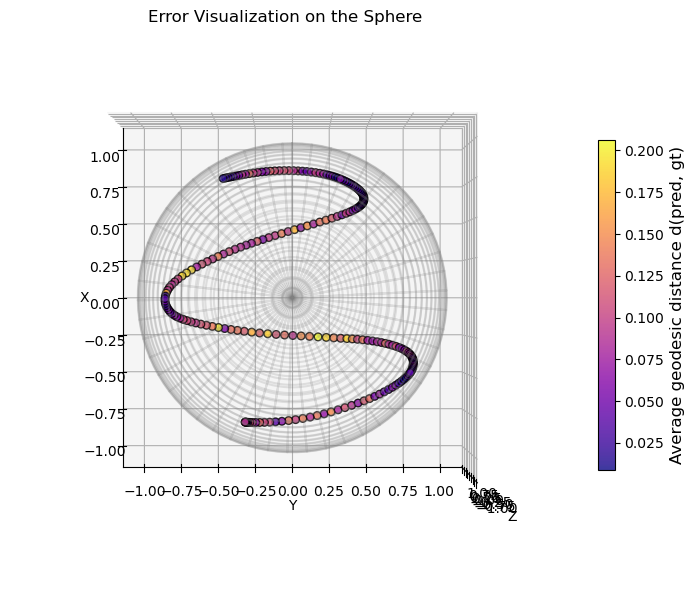

In [268]:
plot_error_on_sphere(dataset.demos[6], quat_error)

In [269]:
quat_error.mean().item()

0.08074745535850525

In [ ]:
def trajectory_geodesic_stats(trajectories):
    N = len(trajectories)
    num_points, dim = trajectories[0].shape

    traj_tensor = torch.stack(trajectories, dim=0)

    means = []
    variances = []

    for t in range(num_points):
        points_t = traj_tensor[:, t, :]
        mean_vec = points_t.mean(dim=0)
        mean_vec = mean_vec / mean_vec.norm()
        means.append(mean_vec)

        dists = geodesic_distance(points_t, mean_vec)
        variances.append((dists ** 2).mean())

    return torch.stack(means), torch.stack(variances)

In [22]:
mean, std = trajectory_geodesic_stats(results)

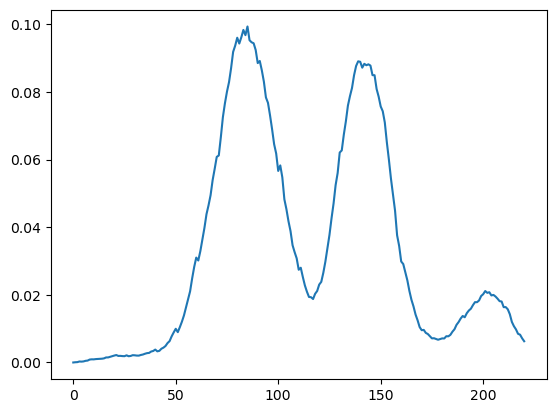

In [27]:
plt.plot(std)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_geodesic_stats_on_sphere(means, variances, label, elev=-90, azim=0):
    if isinstance(means, torch.Tensor):
        means = means.cpu().numpy()
    if isinstance(variances, torch.Tensor):
        variances = variances.cpu().numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

    p = ax.scatter(means[:, 0], means[:, 1], means[:, 2],
                   c=variances, cmap='plasma', s=40, label="Geodesic Mean")

    cb = plt.colorbar(p, ax=ax, shrink=0.7)
    cb.set_label("Variance")

    ax.view_init(elev=elev, azim=azim)
    ax.set_title(label + " var of trajectory")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.show()


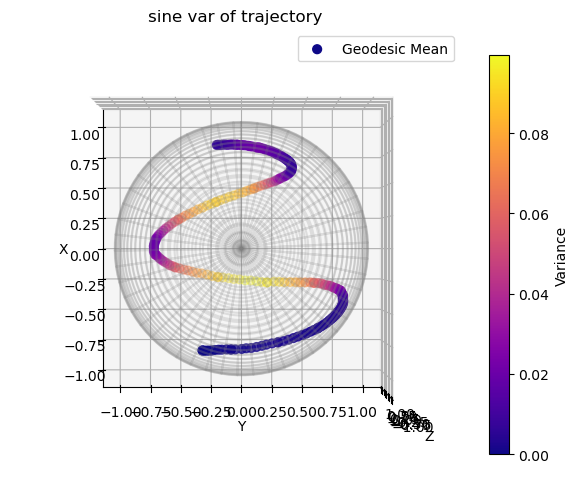

In [24]:
plot_geodesic_stats_on_sphere(mean, std, label="sine")

In [9]:
def plot_points(points, 
                title="3D Scatter Plot", 
                color="blue", 
                s=20, 
                show_grid=True,
                elev=0,
                azim=0):
    if isinstance(points, torch.Tensor):
        points = points.cpu().numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

   # print(points.shape)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, s=s)

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # Optional grid
    ax.grid(show_grid)

    # Set equal aspect ratio
    max_range = (points.max() - points.min()) / 2
    mid = points.mean(axis=0)
    # ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    # ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    # ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

    # Adjust view to center the north pole
    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Flow on the 2-Sphere")
    
    plt.tight_layout()
    # Interactive rotation
    plt.show()

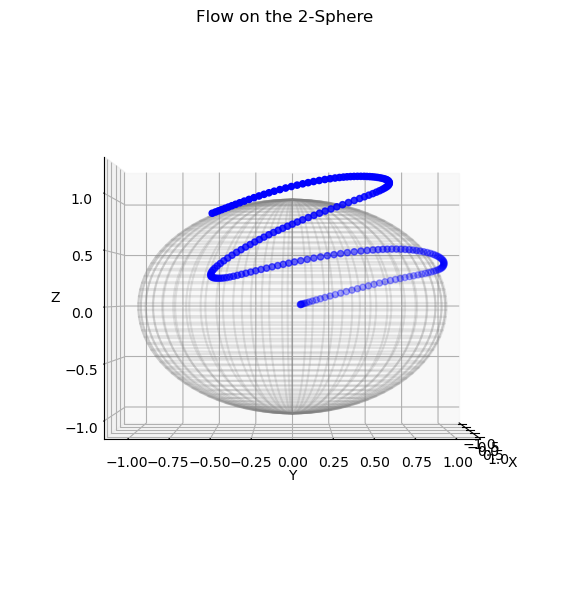

In [10]:
plot_points(gt_obs[0, :, :3], elev=0)

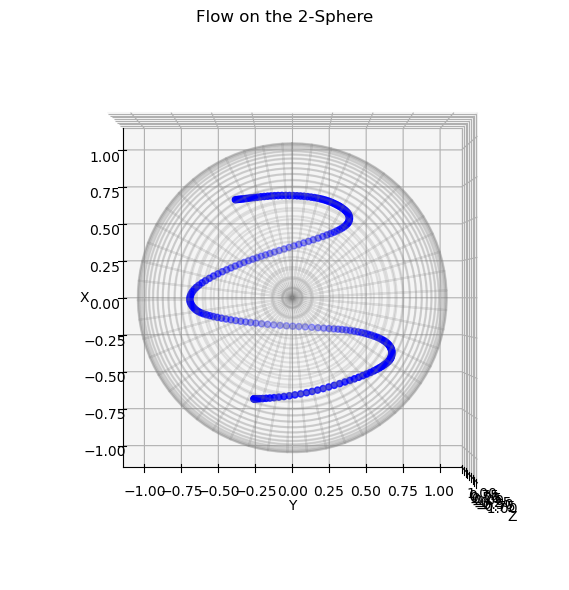

In [26]:
plot_points(dataset.return_data_from_inference_manifold(result_data=gt_obs[0, :, :3], start=dataset.start_points['Sine']), elev=-90)

In [20]:
projected = dataset.return_data_from_inference_manifold(result_data=gt_obs[0, :, :3], start=dataset.start_points['Sine'])

In [21]:
demos_gt_val = dataset.demos_gt[6]

In [22]:
print(demos_gt_val)

tensor([[-0.6721, -0.2549,  0.6952],
        [-0.6722, -0.2540,  0.6954],
        [-0.6724, -0.2514,  0.6962],
        [-0.6725, -0.2465,  0.6978],
        [-0.6724, -0.2392,  0.7004],
        [-0.6721, -0.2287,  0.7042],
        [-0.6716, -0.2147,  0.7092],
        [-0.6706, -0.1964,  0.7153],
        [-0.6692, -0.1743,  0.7223],
        [-0.6674, -0.1490,  0.7296],
        [-0.6651, -0.1210,  0.7368],
        [-0.6621, -0.0896,  0.7441],
        [-0.6581, -0.0553,  0.7509],
        [-0.6532, -0.0193,  0.7570],
        [-0.6474,  0.0177,  0.7619],
        [-0.6406,  0.0562,  0.7658],
        [-0.6329,  0.0949,  0.7684],
        [-0.6246,  0.1320,  0.7697],
        [-0.6155,  0.1689,  0.7699],
        [-0.6054,  0.2061,  0.7688],
        [-0.5948,  0.2432,  0.7662],
        [-0.5837,  0.2799,  0.7622],
        [-0.5724,  0.3161,  0.7566],
        [-0.5611,  0.3508,  0.7497],
        [-0.5502,  0.3834,  0.7418],
        [-0.5397,  0.4137,  0.7333],
        [-0.5290,  0.4424,  0.7242],
 

In [23]:
print(projected)

tensor([[-0.6721, -0.2549,  0.6952],
        [-0.6722, -0.2540,  0.6954],
        [-0.6724, -0.2514,  0.6962],
        [-0.6725, -0.2465,  0.6978],
        [-0.6724, -0.2392,  0.7004],
        [-0.6721, -0.2287,  0.7042],
        [-0.6716, -0.2147,  0.7092],
        [-0.6706, -0.1964,  0.7153],
        [-0.6692, -0.1743,  0.7223],
        [-0.6674, -0.1490,  0.7296],
        [-0.6651, -0.1210,  0.7368],
        [-0.6621, -0.0896,  0.7441],
        [-0.6581, -0.0553,  0.7509],
        [-0.6532, -0.0193,  0.7570],
        [-0.6474,  0.0177,  0.7619],
        [-0.6406,  0.0562,  0.7658],
        [-0.6329,  0.0949,  0.7684],
        [-0.6246,  0.1320,  0.7697],
        [-0.6155,  0.1689,  0.7699],
        [-0.6054,  0.2061,  0.7688],
        [-0.5948,  0.2432,  0.7662],
        [-0.5837,  0.2799,  0.7622],
        [-0.5724,  0.3161,  0.7566],
        [-0.5611,  0.3508,  0.7497],
        [-0.5502,  0.3834,  0.7418],
        [-0.5397,  0.4137,  0.7333],
        [-0.5290,  0.4424,  0.7242],
 

In [ ]:
results_euc = torch.load('euclidean_inference.pt', weights_only=True)
samples_euc = torch.load('euclidean_samples.pt', weights_only=True)

In [ ]:
results_euc_proj = wrap(manifold=manifold, samples=results_euc[0])
samples_euc_proj = wrap(manifold=manifold, samples=samples_euc[0])

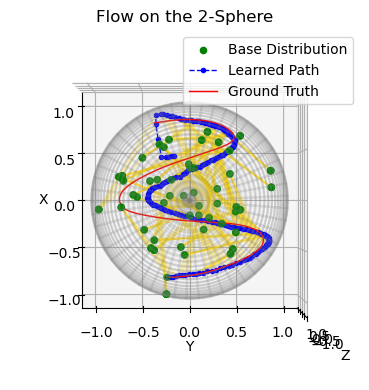

In [ ]:
plot_flow_on_sphere(results_list=[results_euc_proj], samples_list=[samples_euc_proj], gt_samples=gt_obs)

In [ ]:
print(criterion(results_euc_proj[:50], gt_obs[1:50,:3]))

tensor(0.6719)


In [251]:
def plot_gt_on_sphere(gt_samples):

    def plot_sphere(elev, azim):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        for i in range(len(gt_samples)):
            ax.plot(gt_samples[i][:, 0].numpy(), gt_samples[i][:, 1].numpy(), gt_samples[i][:, 2].numpy(), color="blue", linewidth=1)

        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 50)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

    plt.tight_layout()
    plt.show()
    plot_sphere(-90, 0)

<Figure size 640x480 with 0 Axes>

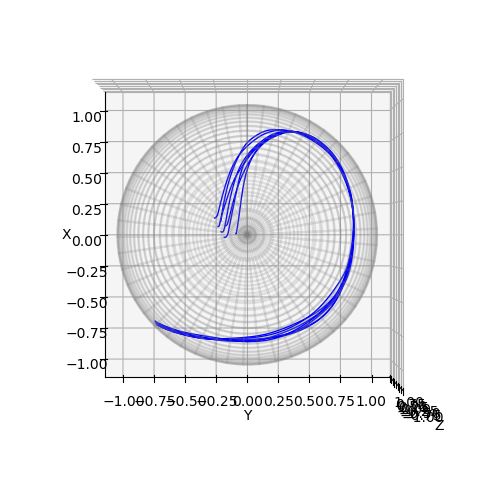

In [252]:
plot_gt_on_sphere(dataset.demos)